In [2]:
!pip install torch

In [3]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import torch.optim as optim
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

In [4]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,) , (0.5,))
])
def load_data():
  train_dataset = FashionMNIST(root='/content/drive/MyDrive', train=True, download=True, transform=transform)
  test_dataset = FashionMNIST(root='/content/drive/MyDrive', train=False, download=True, transform=transform)

  train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

  return train_loader, test_loader

In [5]:
class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, in_channels, out_channels, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_channels != self.expansion * out_channels:
      self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
      out = self.relu(self.bn1(self.conv1(x)))
      out = self.bn2(self.conv2(out))
      out = self.relu(out)

      return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = self.relu(out)

        return out


In [6]:
class ResNet50(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet50, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[1], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [20]:
def train_model(model, train_loader, test_loader):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  num_epochs = 10  # Set the number of epochs

  for epoch in range(1, num_epochs + 1):
      model.train()
      running_loss = 0.0
      for i, data in enumerate(train_loader, 1):
          inputs, labels = data[0].to(device), data[1].to(device)  # Ensure data is on the same device as the model

          optimizer.zero_grad()

          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          if i % 100 == 0:
              print(f"Epoch [{epoch}/{num_epochs}], Batch [{i}/{len(train_loader)}], Loss: {running_loss / 100:.4f}")
              running_loss = 0.0

      print(f"Epoch [{epoch}/{num_epochs}] completed")

  print("Finished Training")

  model.eval()
  pred_labels = []
  true_labels = []

  with torch.no_grad():
    for data in test_loader:
      inputs, labels = data[0].to(device, dtype=torch.float), data[1].to(device, dtype=torch.float)
      outputs = model(inputs)
      _, predicted = torch.max(outputs,1)
      pred_labels.extend(predicted.cpu().numpy())
      true_labels.extend(labels.cpu().numpy())


  cm = confusion_matrix(true_labels, pred_labels)
  plt.figure(figsize=(8,6))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.colorbar()
  classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.tight_layout()
  plt.show()

  f1_scores = f1_score(true_labels, pred_labels, average=None)
  for i, f1 in enumerate(f1_scores):
    print(f"F1 Score for class {classes[i]}: {f1:.4f}")


In [21]:
def main():
  train_loader, test_loader = load_data()
  model = ResNet50(Bottleneck, [3, 4, 6, 3], num_classes=10)
  train_model(model, train_loader, test_loader)

Epoch [1/1], Batch [100/938], Loss: 0.9877
Epoch [1/1], Batch [200/938], Loss: 0.6473
Epoch [1/1], Batch [300/938], Loss: 0.5745
Epoch [1/1], Batch [400/938], Loss: 0.5077
Epoch [1/1], Batch [500/938], Loss: 0.4826
Epoch [1/1], Batch [600/938], Loss: 0.4366
Epoch [1/1], Batch [700/938], Loss: 0.4164
Epoch [1/1], Batch [800/938], Loss: 0.3938
Epoch [1/1], Batch [900/938], Loss: 0.3791
Epoch [1/1] completed
Finished Training


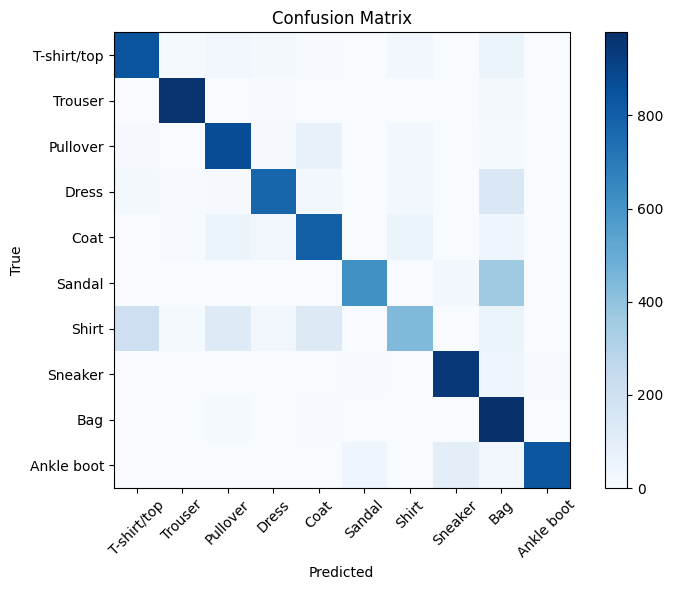

F1 Score for class T-shirt/top: 0.8075
F1 Score for class Trouser: 0.9626
F1 Score for class Pullover: 0.8258
F1 Score for class Dress: 0.8255
F1 Score for class Coat: 0.7850
F1 Score for class Sandal: 0.7398
F1 Score for class Shirt: 0.5565
F1 Score for class Sneaker: 0.9148
F1 Score for class Bag: 0.7126
F1 Score for class Ankle boot: 0.9077


In [22]:
if __name__ == "__main__":
  main()